Plot the increase in magnetisation relative to the uniform baseline for different Ising influence strategies.

Created on 27/09/20

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib
import pylab
import itertools

In [12]:
eval_data = pd.read_csv("Data/Pokec_control_eval_data_no_field.csv")
eval_data

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient
0,0,no con,-0.669473,0.000012,8.0,0.0
1,1,unif,-0.647796,0.000011,8.0,0.0
2,2,full,-0.629465,0.000009,8.0,0.0
3,3,block,-0.646916,0.000018,8.0,0.0
4,4,sv,-0.655798,0.000017,8.0,0.0
...,...,...,...,...,...,...
100,2,full,-0.636380,0.000010,8.0,0.0
101,3,block,-0.650586,0.000011,8.0,0.0
102,4,sv,-0.649837,0.000014,8.0,0.0
103,5,nc,0.006509,0.000036,8.0,0.0


In [2]:
#eval_data = pd.read_csv('Data/Pokec_control_eval_data_new.csv')
#eval_data = pd.read_csv('Data/Pokec_control_eval_data_positive.csv')
#eval_data = pd.read_csv("Data/Pokec_control_eval_data_no_field.csv")
#eval_data = pd.read_csv("Data/Pokec_control_eval_data_beta2_neg.csv")

#eval_data = pd.read_csv("Data/Pokec_control_eval_data_positive_larger_gs.csv").append(pd.read_csv('Data/Pokec_control_eval_data_positive.csv'))
# Pokec_control_eval_data_beta_2-0_1-0
init_sign=1.0

if init_sign==1.0: 
    eval_data = pd.read_csv("Data/Pokec_control_eval_data_positive_start_neg_g.csv").append(pd.read_csv('Data/Pokec_control_eval_data_positive.csv'))
    eval_data = eval_data.loc[eval_data['gradient'].isin(list(np.arange(-10.0,12.0,2.0)))]
    # filter to even only
    eval_data = pd.read_csv("Data/Pokec_control_eval_data_beta_2-0_1-0.csv")
    
    
elif init_sign==-1.0:
    eval_data = pd.read_csv("Data/Pokec_control_eval_data_negative_beta_8_start_neg_g.csv")
eval_data

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient
0,0,no con,-0.051096,0.000020,2.0,-10.0
1,1,unif,-0.037050,0.000026,2.0,-10.0
2,2,full,-0.016640,0.000017,2.0,-10.0
3,3,block,-0.038004,0.000025,2.0,-10.0
4,4,sv,-0.047285,0.000024,2.0,-10.0
...,...,...,...,...,...,...
1150,2,full,0.245675,0.000012,2.0,10.0
1151,3,block,0.248500,0.000021,2.0,10.0
1152,4,sv,0.253687,0.000023,2.0,10.0
1153,5,nc,0.249127,0.000024,2.0,10.0


In [3]:
control_names = ['block','full','nc','sv','snapshot']

In [4]:
beta_choice = 2.0 #8.0 #8.0
eval_data = eval_data.loc[eval_data['beta_factor']==beta_choice]
eval_data['Sample_index'] = eval_data.reset_index().reset_index().groupby(by=['control','gradient','beta_factor'])['level_0'].transform(lambda x: x.rank())

pivotted = pd.pivot_table( eval_data , values=['magnetisation'],columns=['control'] ,index=['beta_factor','gradient','Sample_index'],aggfunc={'magnetisation':np.mean} ).reset_index()
pivotted.columns=pivotted.columns.map('_'.join)
for k in control_names :
    pivotted[f"markup_{k}"] = pivotted[f'magnetisation_{k}'] - pivotted['magnetisation_unif']

grouped = pivotted.groupby(['beta_factor_','gradient_']).agg({f'markup_{k}':[np.mean,stats.sem] for k in control_names}).reset_index()
grouped.columns=grouped.columns.map('_'.join)
grouped.head()

,beta_factor__,gradient__,markup_block_mean,markup_block_sem,markup_full_mean,markup_full_sem,markup_nc_mean,markup_nc_sem,markup_sv_mean,markup_sv_sem,markup_snapshot_mean,markup_snapshot_sem
0,2.0,-10.0,-0.001222,0.001811,0.008189,0.002376,-0.006329,0.002107,-0.001375,0.002620,0.001439,0.003153
1,2.0,-8.0,-0.003142,0.002515,0.008073,0.002453,-0.007584,0.002297,0.002185,0.003217,-0.003826,0.003412
2,2.0,-6.0,0.003144,0.003379,0.014606,0.002623,-0.003386,0.003907,0.004669,0.004037,0.004247,0.003806
3,2.0,-4.0,0.003017,0.003370,0.009482,0.002513,0.002604,0.003508,-0.000002,0.002984,0.001915,0.003060
4,2.0,-2.0,-0.001244,0.003460,0.006984,0.002555,-0.002647,0.003427,0.004042,0.003389,0.002007,0.003689


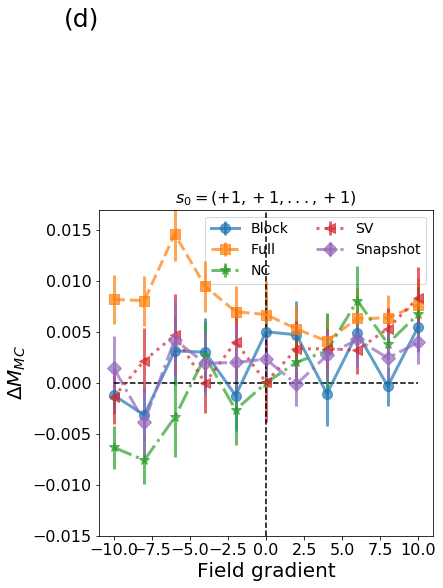

In [11]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    
    #NC control at g=0 should be undefined.
    if con == 'nc' and 0.0 in gradient :
        zero_g_index=gradient.index(0.0)
        mean_markup[zero_g_index]=0.0
        sem_markup[zero_g_index]=0.0
    
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([-10,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(fontsize=14,ncol=2,loc='upper left')
ax.legend(fontsize=14,ncol=2,loc='upper right').set_zorder(0)

#plt.xlim(-11,11)
#plt.xlim(-1,1)
#plt.xlim(-1,19)
#plt.ylim(-0.015,0.038)
plt.ylim(-0.015,0.017)
plt.plot([0,0],[-0.015,0.038],'k--')


if init_sign==-1.0:
    plt.text(-13.3,0.035,'(c)',fontsize=25)
    plt.title("$s_0=(-1,-1,...,-1)$",fontsize=16)
elif init_sign==1.0:
    plt.text(-13.3,0.035,'(d)',fontsize=25)
    plt.title("$s_0=(+1,+1,...,+1)$",fontsize=16)
    

    

plt.savefig(f"Plots/Pokec_markup_as_grad_beta_{beta_choice}_{init_sign}".replace('.','-') + ".jpg",bbox_inches='tight')

In [6]:
single_gradient=eval_data.loc[eval_data['gradient']==0]
single_gradient

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient,Sample_index
525,0,no con,0.132998,0.000017,2.0,0.0,1
526,1,unif,0.142367,0.000017,2.0,0.0,1
527,2,full,0.160343,0.000017,2.0,0.0,1
528,3,block,0.171103,0.000014,2.0,0.0,1
529,4,sv,0.155232,0.000012,2.0,0.0,1
...,...,...,...,...,...,...,...
625,2,full,0.155681,0.000018,2.0,0.0,15
626,3,block,0.163972,0.000018,2.0,0.0,15
627,4,sv,0.175450,0.000012,2.0,0.0,15
628,5,nc,0.002793,0.000026,2.0,0.0,15


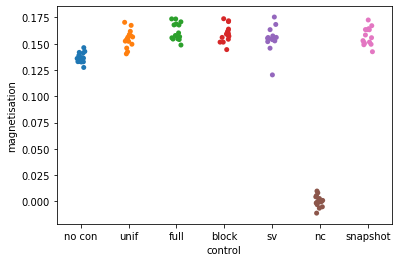

In [7]:
sns.stripplot(data=single_gradient,x='control',y='magnetisation')

In [8]:
np.arange(12.0,19.0,1.0)

array([12., 13., 14., 15., 16., 17., 18.])

## Fraction of full-mf markup

(array([-12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5,
         10. ,  12.5]), <a list of 11 Text xticklabel objects>)

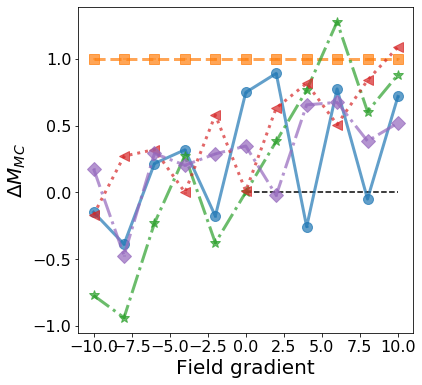

In [9]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    
    mf_full_markup = list(grouped[f'markup_full_mean'])
    
    mean_markup=[i/j for i,j in zip(mean_markup,mf_full_markup)]
    
    #NC control at g=0 should be undefined.
    if con == 'nc' and 0.0 in gradient :
        zero_g_index=gradient.index(0.0)
        mean_markup[zero_g_index]=0.0
        sem_markup[zero_g_index]=0.0
    
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([0,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

## As a fraction above unif

In [10]:
beta_choice = 8.0 #8.0
eval_data = eval_data.loc[eval_data['beta_factor']==beta_choice]
eval_data['Sample_index'] = eval_data.reset_index().reset_index().groupby(by=['control','gradient','beta_factor'])['level_0'].transform(lambda x: x.rank())

pivotted = pd.pivot_table( eval_data , values=['magnetisation'],columns=['control'] ,index=['beta_factor','gradient','Sample_index'],aggfunc={'magnetisation':np.mean} ).reset_index()
pivotted.columns=pivotted.columns.map('_'.join)
for k in control_names :
    pivotted[f"markup_{k}"] = (pivotted[f'magnetisation_{k}'] - pivotted['magnetisation_unif'])/abs(pivotted['magnetisation_unif'])

grouped = pivotted.groupby(['beta_factor_','gradient_']).agg({f'markup_{k}':[np.mean,stats.sem] for k in control_names}).reset_index()
grouped.columns=grouped.columns.map('_'.join)
grouped.head()

KeyError: 'magnetisation_block'

In [ ]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    
    #NC control at g=0 should be undefined.
    if con == 'nc' and 0.0 in gradient :
        zero_g_index=gradient.index(0.0)
        mean_markup[zero_g_index]=0.0
        sem_markup[zero_g_index]=0.0
    
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([-10,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(fontsize=14,ncol=2,loc='upper left')
ax.legend(fontsize=14,ncol=2,loc='upper right').set_zorder(0)